In [87]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

ice_mask = pd.read_csv('data/ice_mask.csv')

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def replace_with_abs(df, columns):
    new_df = df.copy()
    for column in columns:
        new_df[column] = new_df[column].abs()
    return new_df

In [47]:
def doRandomForest(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    category_labels = {2.0: 'grounded_ice', 3.0: 'floating_ice', 4.0: 'open_ocean'}

    # Run the linear regression 30 times
    for i in range(n_runs):
        randomState = i*seed
        # Split the data into training and testing sets
        X = preprocessed_df.iloc[:, :-1] #selects all but the last column 
        y = preprocessed_df.iloc[:, -1] #selects only the last column
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = RandomForestClassifier(random_state=randomState)
        model.fit(X_train, y_train)
        
        importances.append(model.feature_importances_)
        y_predicted = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(accuracy)
        
        cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(cm[0, 0] / cm[0, :].sum() if cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(cm[1, 1] / cm[1, :].sum() if cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(cm[2, 2] / cm[2, :].sum() if cm[2, :].sum() > 0 else 0)

    average_accuracy = np.mean(overall_accuracies)
    average_importances = np.mean(importances, axis=0)
    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    
        
    print (f"Average Accuracy: {average_accuracy:,.3f}")
    print (f"Average Feature Importance:", average_importances)
    print("Average Category Accuracies:")
    for category, acc in average_category_accuracies.items():
        print(f"  {category}: {acc:.3f}")
    return average_accuracy, average_importances, average_category_accuracies


In [77]:
#++++++++++++++++++++++++++++++++++++++++++RANDOM FOREST CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(ice_mask)

rf_accuracies, rf_importances, rf_category_accuracies = doRandomForest(scaled_df, seed, 30)


Average Accuracy: 0.963
Average Feature Importance: [0.04714329 0.04570688 0.24677296 0.55838563 0.10199124]
Average Category Accuracies:
  grounded_ice: 0.974
  floating_ice: 0.464
  open_ocean: 0.990


In [49]:
#++++++++++++++++++++++++++++++++++++++++++RANDOM FOREST CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++
seed = 101
abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)

rf_accuracies_abs, rf_importances_abs, rf_category_accuracies_abs = doRandomForest(abs_scaled_df, seed, 30)


Average Accuracy: 0.965
Average Feature Importance: [0.03749123 0.06972665 0.24384083 0.55303175 0.09590953]
Average Category Accuracies:
  grounded_ice: 0.977
  floating_ice: 0.489
  open_ocean: 0.991


In [62]:
def doSVM(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    coef_importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    category_labels = {2.0: 'grounded_ice', 3.0: 'floating_ice', 4.0: 'open_ocean'}

    # Run the SVM classification 30 times
    for i in range(n_runs):
        randomState = i * seed
        # Split the data into training and testing sets
        X = preprocessed_df.iloc[:, :-1]  # selects all but the last column 
        y = preprocessed_df.iloc[:, -1]   # selects only the last column
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='linear', random_state=randomState)
        model.fit(X_train, y_train)
            
        coef_importances.append(model.coef_[0])
        
        y_predicted = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(accuracy)
        
        cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(cm[0, 0] / cm[0, :].sum() if cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(cm[1, 1] / cm[1, :].sum() if cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(cm[2, 2] / cm[2, :].sum() if cm[2, :].sum() > 0 else 0)

    average_accuracy = np.mean(overall_accuracies)
    average_coef_importances = np.mean(coef_importances, axis=0)
    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    
    print(f"Average Accuracy: {average_accuracy:.3f}")
    print("Average Coefficient Importances:", average_coef_importances)
    print("Average Category Accuracies:")
    for category, acc in average_category_accuracies.items():
        print(f"  {category}: {acc:.3f}")

    return average_accuracy, average_category_accuracies, average_coef_importances


In [63]:
#++++++++++++++++++++++++++++++++++++++++++++++SVC CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++++
scaled_df = scale(ice_mask)
svm_accuracy, svm_catagory_accuracies, svm_coef_importances= doSVM(scaled_df, seed, 30)

Average Accuracy: 0.950
Average Coefficient Importances: [-0.02436612  0.01066642 -0.08166527  0.10287005  0.01437589]
Average Category Accuracies:
  grounded_ice: 0.978
  floating_ice: 0.000
  open_ocean: 0.994


In [65]:
#++++++++++++++++++++++++++++++++++++++++++++SVC CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++
abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
svm_accuracy_abs, svm_catagory_accuracies_abs, svm_coef_importances_abs= doSVM(abs_scaled_df, seed, 30)

Average Accuracy: 0.952
Average Coefficient Importances: [ 0.04301767  0.01972763 -0.10243462  0.09507223  0.01862005]
Average Category Accuracies:
  grounded_ice: 0.983
  floating_ice: 0.000
  open_ocean: 0.995


In [71]:
def doMLP(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    perm_importances = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    # Run the MLP classification n_runs times
    for i in range(n_runs):
        randomState = i * seed
        # Split the data into training and testing sets
        X = preprocessed_df.iloc[:, :-1]  # selects all but the last column 
        y = preprocessed_df.iloc[:, -1]   # selects only the last column
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = MLPClassifier(max_iter = 1000, random_state=randomState)
        model.fit(X_train, y_train)
        
        y_predicted = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(accuracy)
        
        # Calculate permutation feature importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=randomState)
        perm_importances.append(perm_importance.importances_mean)

        cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(cm[0, 0] / cm[0, :].sum() if cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(cm[1, 1] / cm[1, :].sum() if cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(cm[2, 2] / cm[2, :].sum() if cm[2, :].sum() > 0 else 0)

    average_accuracy = np.mean(overall_accuracies)
    average_perm_importances = np.mean(perm_importances, axis=0)
    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    
    print(f"Average Accuracy: {average_accuracy:.3f}")
    print("Average Permutation Importances:", average_perm_importances)
    print("Average Category Accuracies:")
    for category, acc in average_category_accuracies.items():
        print(f"  {category}: {acc:.3f}")

    return average_accuracy, average_perm_importances, average_category_accuracies


In [82]:
#+++++++++++++++++++++++++++++++++++++++++++++++MLP CLASSIFICATION+++++++++++++++++++++++++++++++++++++++++++++++
scaled_df = scale(ice_mask)
mlp_accuracy, mlp_perm_importances, mlp_average_catagory_accuracies = doMLP(scaled_df, seed, 30)

Average Accuracy: 0.950
Average Permutation Importances: [1.97148476e-03 3.68731563e-04 1.41396264e-02 4.78593904e-01
 3.50049164e-03]
Average Category Accuracies:
  grounded_ice: 0.982
  floating_ice: 0.030
  open_ocean: 0.990


In [83]:
#++++++++++++++++++++++++++++++++++++++++++++MLP CLASSIFICATION ABS XY++++++++++++++++++++++++++++++++++++++++++++
abs_df=abs_df = replace_with_abs(ice_mask, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
mlp_accuracy_abs, mlp_perm_importances_abs, mlp_average_catagory_accuracies_abs = doMLP(abs_scaled_df, seed, 30)

Average Accuracy: 0.956
Average Permutation Importances: [0.00945428 0.00350049 0.01277778 0.48884956 0.00572271]
Average Category Accuracies:
  grounded_ice: 0.984
  floating_ice: 0.166
  open_ocean: 0.991


In [84]:
#+++++++++++++++++++++++++++++++++++++++++ GETTING DFS FOR PLOTTING ++++++++++++++++++++++++++++++++++++++
cols = ['x-axis', 'y-axis', "precipitation", "air_temp", "ocean_temp"]

rf_importances_df = pd.DataFrame(columns=cols)
rf_importances_df.loc[len(rf_importances_df)] = rf_importances


abs_rf_importances_df = pd.DataFrame(columns=cols)
abs_rf_importances_df.loc[len(abs_rf_importances_df)] = rf_importances_abs

svm_coef_importances_df = pd.DataFrame(columns=cols)
svm_coef_importances_df.loc[len(svm_coef_importances_df)] = svm_coef_importances

abs_svm_coef_importances_df = pd.DataFrame(columns=cols)
abs_svm_coef_importances_df.loc[len(abs_svm_coef_importances_df)] = svm_coef_importances_abs

mlp_perm_importances_df = pd.DataFrame(columns=cols)
mlp_perm_importances_df.loc[len(mlp_perm_importances_df)] = mlp_perm_importances

abs_mlp_perm_importances_df = pd.DataFrame(columns=cols)
abs_mlp_perm_importances_df.loc[len(mlp_perm_importances_df)] = mlp_perm_importances_abs

In [88]:
##+++++++++++++++++++++++++++++++++++++++++++++++PLOTTING FEATURES+++++++++++++++++++++++++++++++++++++++++++++
def plot_coefficients(coef_df, title):
    for column in coef_df.columns: 
            coef_df[column] = coef_df[column].abs()
            
    transposed_linreg_coef = coef_df.T
    transposed_linreg_coef.reset_index(inplace=True)
    transposed_linreg_coef.columns = ['Feature', 'Coefficient']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_linreg_coef['Feature'], transposed_linreg_coef['Coefficient'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    
def plot_importance(importance_df, title):
    for column in importance_df.columns: 
            importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_permutations(perm_df, title):
    for column in perm_df.columns: 
            perm_df[column] = perm_df[column].abs()
            
    transposed_perm_df = perm_df.T
    transposed_perm_df.reset_index(inplace=True)
    transposed_perm_df.columns = ['Feature', 'Importance']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_perm_df['Feature'], transposed_perm_df['Importance'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Permutation Change')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    

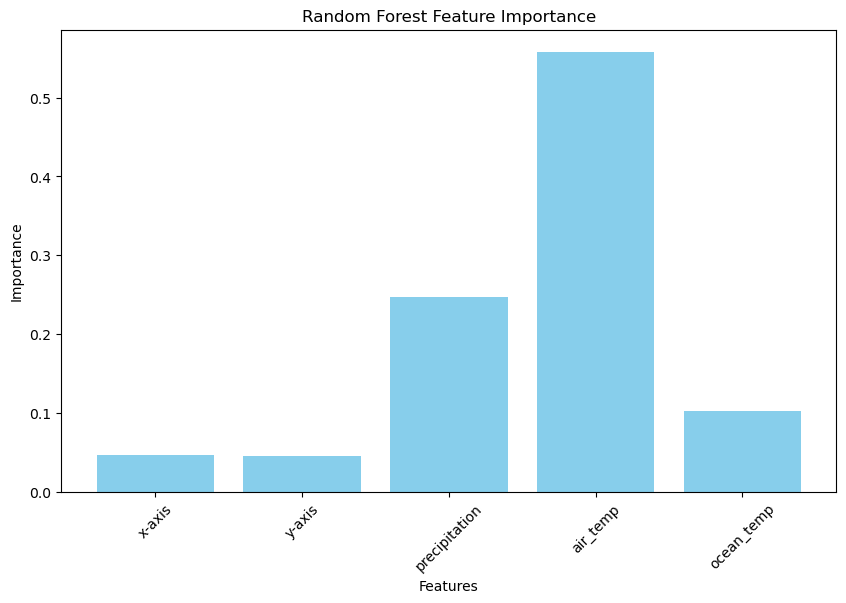

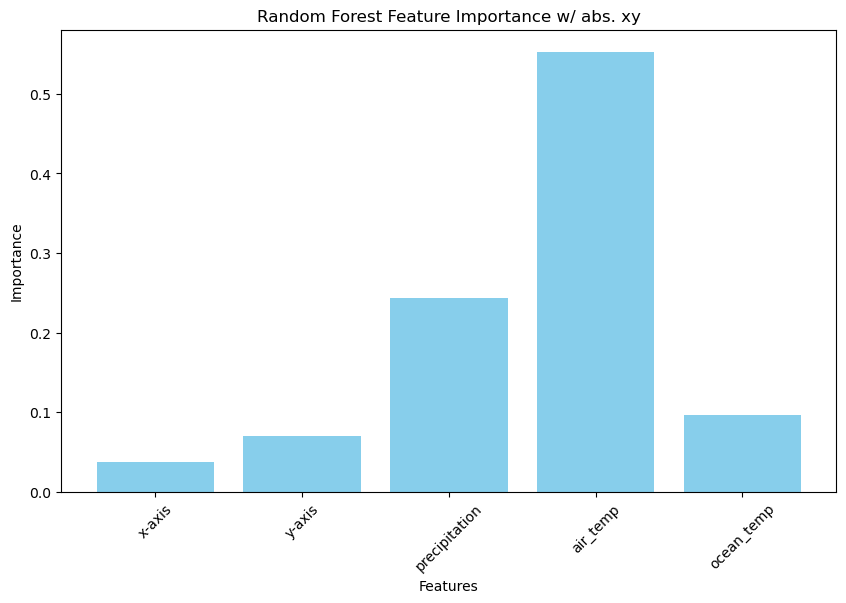

In [90]:
plot_importance(rf_importances_df, "Random Forest Feature Importance")
plot_importance(abs_rf_importances_df, "Random Forest Feature Importance w/ abs. xy")


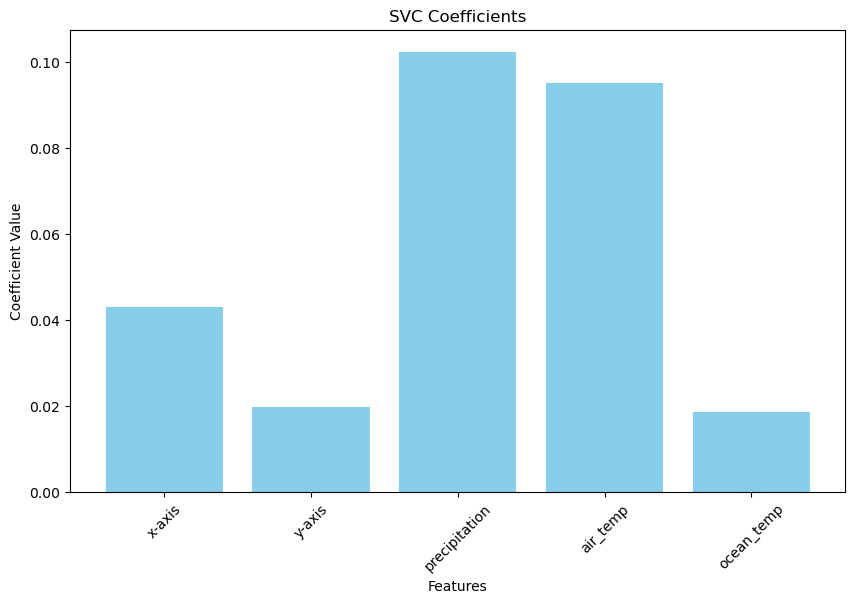

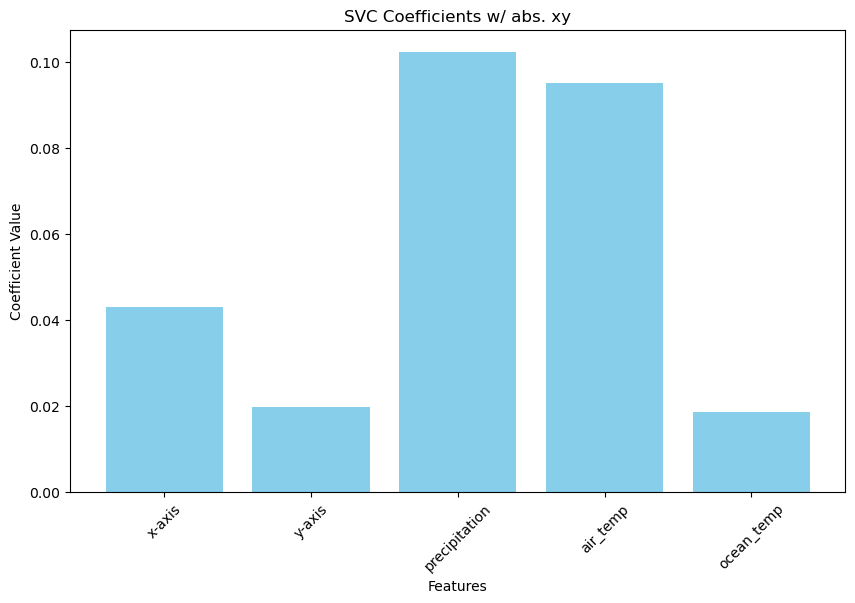

In [91]:
plot_coefficients(svm_coef_importances_df, "SVC Coefficients")
plot_coefficients(abs_svm_coef_importances_df, "SVC Coefficients w/ abs. xy")


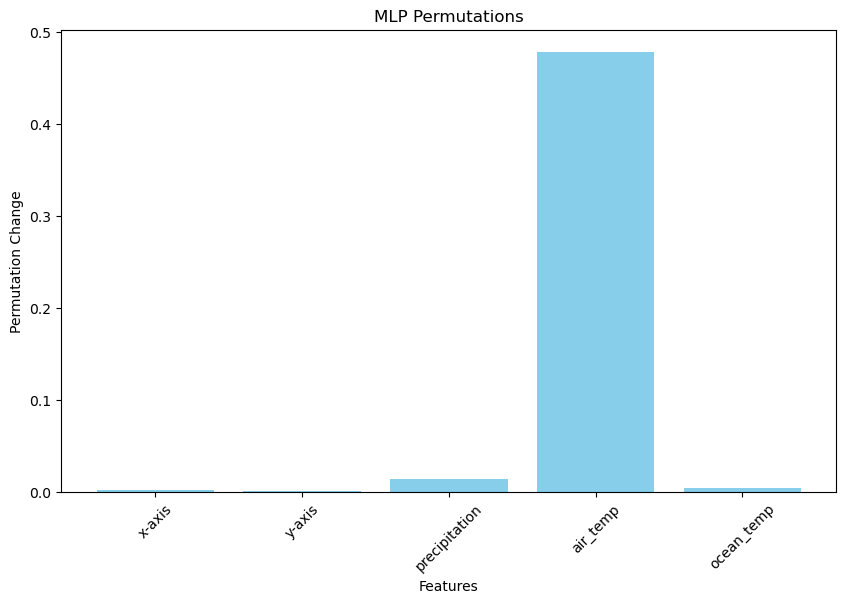

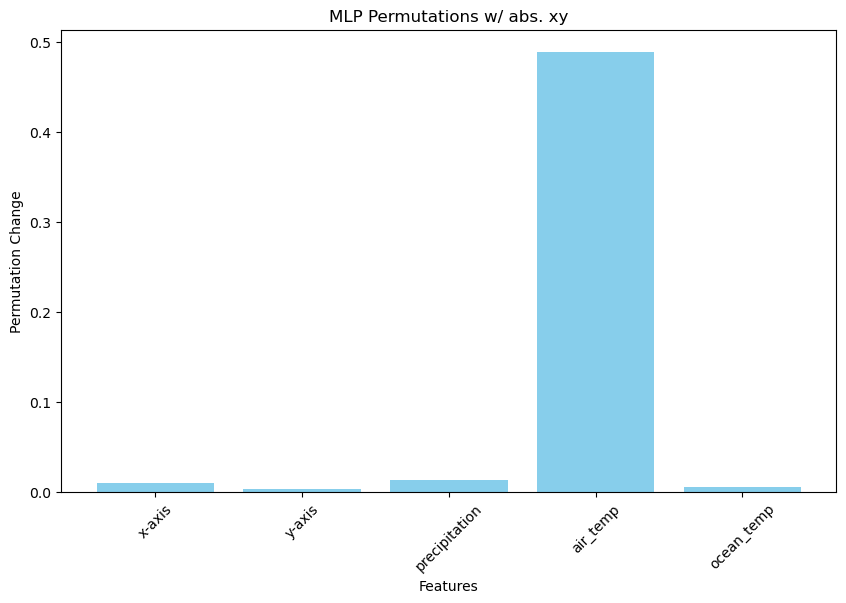

In [92]:
plot_permutations(mlp_perm_importances_df, "MLP Permutations")
plot_permutations(abs_mlp_perm_importances_df, "MLP Permutations w/ abs. xy")
